In [2]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# The LondON Precipitation Project
<hr />
## 1.1 Project Goals
The primary goal of this analysis is to answer the investigate question of whether or not London Ontario has experienced **more precipitation in 2017 than in other years**.  People  assume we've experienced more precipitation this year but there are no sources that I've come accross that quantitatively describe this year's overall precipitation.  While we could use statistical methods such as [t-tests](https://en.wikipedia.org/wiki/Student%27s_t-test) or [ANOVA](#http://vassarstats.net/textbook/ch13pt1.html), the analyis is limited to visualizations and summary statistics.  These methods will be sufficient in answering our primary research question of weather or not it has rained more this year than in previous years and by how much.

The secondary goal is to create a model that captures the generative process of high-precipitation or rainy days that can be used to model the likelihood of observing N rain days in a seven day period.  In capturing how this weekly frequency changes over time, we can answer questions like "Is it raining more frequently on a weekly basis?" or "What is the probability that it will rain 5/7 days next week?"

## 1.2 Data
Climate Canada provides access to historical weather data via [[1]](http://climate.weather.gc.ca/historical_data/search_historic_data_e.html).  The data is produced by sensors at various weather station locations spread throughout the country.  A user can retrieve historical weather station data using a search system that accepts queries for station data by name, province, or proximity [FIGURE 1].  

[FIGURE 1]

After selecting a station, the user can request data at hourly, daily, or monthly intervals [FIGURE 2].  The availability for a particular interval varies accross stations; some stations are missing data entire months.  This analysis will focus on data from weather stations deployed in London Ontario, Canada so the search term used to find relevant stations and the associated data included only the keyword 'London'.  

After using the Climate Canada web app to identify stations in London Ontario, only those with monthly data available for at least five years were considered for the analysis.  Monthly station data was retrieved from Climate Canada's web application using a Python program built using the web scraping framework Scrapy[[2]](#).  The program retrieves station data for each station for every month from January 1, 2012 to July 2, 2017 and generates a CSV file where each row represents a single observation for one of the three stations 

[FIGURE 2]

Scraper code can be found in [[3]](#).

In [3]:
# Load daily weather data produced by web scraper
dwd = pd.read_csv("../../data/daily_weather_2017_06_29.csv")

The variables include those listed below.  Full descriptions of the variables can be found at [[4](http://climate.weather.gc.ca/glossary_e.html)].

In [4]:
pd.DataFrame(index=dwd.describe().transpose().index)

""
station
date
maxTemp
minTemp
meanTemp
heatDegDays
coolDegDays
totalRainMM
totalSnowCM
totalPrecipMM


Look at the first few observations

In [5]:
dwd.head()

,station,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,London A,2010-03-01,,,,,,,,,,,
1,London A,2010-03-02,,,,,,,,,,,
2,London A,2010-03-03,,,,,,,,,,,
3,London A,2010-03-04,,,,,,,,,,,
4,London A,2010-03-05,,,,,,,,,,,


In [6]:
dwd.shape

(6133, 13)

6133 observatiions, 13 variables

In [7]:
dwd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6133 entries, 0 to 6132
Data columns (total 13 columns):
station               6133 non-null object
date                  6133 non-null object
maxTemp               6107 non-null object
minTemp               6116 non-null object
meanTemp              6096 non-null object
heatDegDays           6096 non-null object
coolDegDays           6096 non-null object
totalRainMM           1458 non-null object
totalSnowCM           1296 non-null object
totalPrecipMM         3981 non-null object
snowOnGroundCM        5970 non-null object
dirOfMaxGust10sDEG    3404 non-null object
spdOfMaxGustKMH       3404 non-null object
dtypes: object(13)
memory usage: 623.0+ KB


We need to create the appropriate data types

## 1.3 Data Prep

In [20]:
# Discrete columns
disc = ['station', 'date']

In [28]:
# Continuous data with empty values replaced with None
data_cont = pd.DataFrame.replace(
  pd.DataFrame(dwd[dwd.columns.drop(disc)]),
  ["\xa0", "<31"],
  ["NaN", 31]).astype(float)
data_disc = dwd[disc]

Discrete

In [29]:
pd.DataFrame(index=disc)

""
station
date


Continuous

In [30]:
pd.DataFrame(index=data_cont.columns)

""
maxTemp
minTemp
meanTemp
heatDegDays
coolDegDays
totalRainMM
totalSnowCM
totalPrecipMM
snowOnGroundCM
dirOfMaxGust10sDEG


Final dataset

In [31]:
df = pd.concat([data_cont, data_disc], axis=1)

In [33]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
maxTemp,4640.0,13.308922,11.621668,-19.0,3.6,14.4,23.7,36.7
minTemp,4649.0,3.298688,10.096734,-30.5,-3.3,3.4,11.5,24.6
meanTemp,4629.0,8.314798,10.714802,-24.5,0.2,8.9,17.6,30.7
heatDegDays,4629.0,10.477641,9.741885,0.0,0.4,9.1,17.8,42.5
coolDegDays,4629.0,0.792439,1.814742,0.0,0.0,0.0,0.0,12.7
totalRainMM,1243.0,1.555591,4.482425,0.0,0.0,0.0,0.0,39.3
totalSnowCM,1081.0,1.289917,3.106823,0.0,0.0,0.0,1.0,35.0
totalPrecipMM,3766.0,2.702045,5.978572,0.0,0.0,0.0,2.5,69.7
snowOnGroundCM,1553.0,7.864134,10.661628,0.0,0.0,3.0,11.0,59.0
dirOfMaxGust10sDEG,124.0,20.459677,10.283303,1.0,13.0,20.0,30.0,36.0


In [34]:
df.isnull().sum()

maxTemp               1493
minTemp               1484
meanTemp              1504
heatDegDays           1504
coolDegDays           1504
totalRainMM           4890
totalSnowCM           5052
totalPrecipMM         2367
snowOnGroundCM        4580
dirOfMaxGust10sDEG    6009
spdOfMaxGustKMH       4196
station                  0
date                     0
dtype: int64

Missing values by station

In [35]:
df.groupby('station').apply(lambda x: pd.isnull(x).sum())

,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH,station,date
station,,,,,,,,,,,,,
London A,75,74,77,77,77,2008,2008,2008,2008,1884,78,0,0
London Airport,1389,1389,1389,1389,1389,182,308,301,210,1389,1389,0,0
London CS,29,21,38,38,38,2700,2736,58,2362,2736,2729,0,0


## 1.4 Missing Data

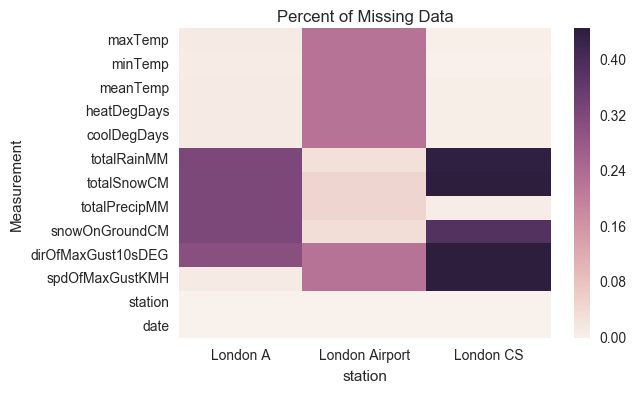

In [42]:
_ = sns.heatmap((df.groupby('station').apply(lambda x: pd.isnull(x).sum()) / df.shape[0]).transpose())
_.set_title("Percent of Missing Data");
_.set_ylabel("Measurement");

* **London A** is missing precipitation data but not much else
* **London Airport** is missing temperature and wind data but has most complete rain data
* **London CS** is missing significant wind, rain, and snow measurements

The only variable we don't have significant sensor coverage for is `dirOfMaxGust10sDEG`.  With a sufficient amount of available data from a combination of the three stations we can use an average to produce daily observations.

## 1.5 Daily Observation Data
Each daily set of observations from the three sensors will produce average measurements that will be used throughout the rest of this analysis.

In [43]:
by_date_df = df.groupby('date').mean()
by_date_df.head()

,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
date,,,,,,,,,,,
2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN


In [44]:
# Save the data
by_date_df.to_csv("../../data/weather_by_day_2017_06_03.csv")
by_date_df_csv = pd.read_csv("../../data/weather_by_day_2017_06_03.csv", date_parser=['date'])
print(by_date_df_csv.info())
by_date_df_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 12 columns):
date                  2736 non-null object
maxTemp               2735 non-null float64
minTemp               2736 non-null float64
meanTemp              2735 non-null float64
heatDegDays           2735 non-null float64
coolDegDays           2735 non-null float64
totalRainMM           1208 non-null float64
totalSnowCM           1081 non-null float64
totalPrecipMM         2697 non-null float64
snowOnGroundCM        1201 non-null float64
dirOfMaxGust10sDEG    124 non-null float64
spdOfMaxGustKMH       1930 non-null float64
dtypes: float64(11), object(1)
memory usage: 256.6+ KB
None


,date,maxTemp,minTemp,meanTemp,heatDegDays,coolDegDays,totalRainMM,totalSnowCM,totalPrecipMM,snowOnGroundCM,dirOfMaxGust10sDEG,spdOfMaxGustKMH
0,2010-01-01,0.0,-9.2,-4.6,22.6,0.0,0.0,15.0,4.9,0.0,NaN,NaN
1,2010-01-02,-9.2,-14.1,-11.7,29.7,0.0,0.0,6.0,4.1,15.0,NaN,NaN
2,2010-01-03,-5.6,-12.6,-9.1,27.1,0.0,0.0,1.0,1.1,20.0,NaN,NaN
3,2010-01-04,-7.5,-11.2,-9.4,27.4,0.0,0.0,1.0,0.5,14.0,NaN,NaN
4,2010-01-05,-3.5,-8.9,-6.2,24.2,0.0,0.0,NaN,0.0,15.0,NaN,NaN
